---
title: "Data Science Design Pattern for Student Drop Out"
author: "Microsoft"
output: 
    rmarkdown::html_vignette:
        toc: true

vignette: >
  %\VignetteIndexEntry{Vignette Title}
  %\VignetteEngine{knitr::rmarkdown}
  %\VignetteEncoding{UTF-8}
---

In [2]:

knitr::opts_chunk$set(fig.width = 6,
                      fig.height = 4,
                      fig.align='center',
                      dev = "png")


# Introducation

Welcome to the Data Science Design Pattern for Student Drop Out. This pattern provides a starting point for the data scientist exploring a new dataset. By no means is it the end point of the data science journey. The pattern is under regular revision and improvement and is provided as is. 

We now introduce a generic pattern for building multiple binary classification models using R.

# Pre-configuration

We load the R packages required for modelling.

In [3]:
########################################################################
# R SETUP

# Load required packages from local library into R.

library(magrittr)     # Data pipelines: %>% %T>% %<>%.
library(stringi)      # String operator: %s+%.
library(rattle)       # Evaluate using riskchart().
library(mlr)          # Dependency of unbalanced.
library(unbalanced)   # Resampling using ubSMOTE.
library(rpart)        # Model: decision tree.
library(rpart.plot)   # Draw fancyRpartPlot().
library(randomForest) # Model: random forest.
library(ada)          # Model: ada boosting.
library(party)        # Model: ctree and cforest.
library(e1071)        # Model: support vector machine.
library(nnet)         # Model: neural network.
library(Matrix)       # Construct a Matrix of a class that inherits from Matrix.
library(caret)        # Tune model hyper-parameters.
library(xgboost)      # Model: extreme gradiant boosting.
library(Ckmeans.1d.dp)# Plot feature importance using xgb.plot.importance.
library(DiagrammeR)   # Plot xgboost tree using xgb.plot.tree.
library(ROCR)         # Use prediction() for evaluation.
library(pROC)         # Use auc() for evaluation. 
library(ggplot2)      # Visually evaluate performance.

Rattle: A free graphical interface for data mining with R.
Version 4.1.0 Copyright (c) 2006-2015 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.
Loading required package: BBmisc
Loading required package: ggplot2
Loading required package: ParamHelpers
Loading required package: foreach
Loading required package: doParallel
Loading required package: iterators
Loading required package: parallel
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

Loading required package: grid

Attaching package: 'grid'

The following object is masked from 'package:BBmisc':

    explode

Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.nume

# Step 4.4: Re-load Dataset

In the Data template we loaded the studentDropIndia dataset, processed it, and saved it to file. Here we re-load the dataset and review its contents. In addition, we define some support functions for evaluation.

In [4]:
########################################################################
# DATA INGESTION

# Identify the dataset.

dsname <- "studentDropIndia"

# We define some support functions that we often find useful.

evaluateModel <- function(data, observed, predicted) 
{ 
  # Calculate the confusion matrix
  
  confusion <- table(data[[observed]], data[[predicted]], dnn=c("Observed", "Predicted"))
  confusion %>% print()
  
  # Calculate the performance metrics
  
  tp <- confusion[rownames(confusion) == 1, colnames(confusion) == 1]
  fn <- confusion[rownames(confusion) == 1, colnames(confusion) == 0]
  fp <- confusion[rownames(confusion) == 0, colnames(confusion) == 1]
  tn <- confusion[rownames(confusion) == 0, colnames(confusion) == 0]
  
  accuracy <- (tp + tn) / (tp + fn + fp + tn)
  precision <- tp / (tp + fp)
  recall <- tp / (tp + fn)
  fscore <- 2 * (precision * recall) / (precision + recall)
  
  # Construct the vector of performance metrics
  
  metrics <- c("Accuracy" = accuracy,
               "Precision" = precision,
               "Recall" = recall,
               "F-Score" = fscore)
  
  # Return the vector of performance metrics
  
  return(metrics)
}

rocChart <- function(pr, target)
{
  # Calculate the true positive and the false positive rates.
  
  rates <- pr %>%
    prediction(target) %>%
    performance("tpr", "fpr")
  
  # Calulcate the AUC.
  
  auc <- pr %>%
    prediction(target) %>%
    performance("auc") %>%
    attr("y.values") %>%
    extract2(1)
  
  # Construct the plot.
  
  pl <- data.frame(tpr=attr(rates, "y.values")[[1]], 
                   fpr=attr(rates, "x.values")[[1]]) %>%
    ggplot(aes(fpr, tpr)) +
    geom_line() +
    annotate("text", x=0.875, y=0.125, vjust=0,
             label=paste("AUC =", round(100*auc, 2)), 
             family="xkcd") +
    xlab("False Positive Rate (1-Specificity)") +
    ylab("True Positive Rate (Sensitivity)")
  
  # Return the plot object.
  
  return(pl)
}

# Identify the dataset to load.

fpath  <- "data"
dsdate <- "_" %s+% "20161215"

# Filename of the saved dataset.

dsrdata <-
  file.path(fpath, dsname %s+% dsdate %s+% ".RData") %T>% 
  print()

[1] "data/studentDropIndia_20161215.RData"


In [5]:
# Load the R objects from file and list them.

load(dsrdata) %>% print()

 [1] "ds"     "dsname" "dspath" "dsdate" "nobs"   "vars"   "target" "id"    
 [9] "ignore" "omit"   "inputi" "inputs" "numi"   "numc"   "cati"   "catc"  


In [6]:
# Review the metadata.

dsname
dspath
dsdate
nobs
vars
target
id
ignore
omit

[1] "studentDropIndia"

[1] "C:/Users/zhouf/Documents/Revolution Analytics/Projects/Education2/Demo/studentDropIndia_20161215.csv"

[1] "_20161215"

[1] 19100

[1] "continue_drop"      "gender"             "caste"             
 [4] "mathematics_marks"  "english_marks"      "science_marks"     
 [7] "science_teacher"    "languages_teacher"  "guardian"          
[10] "internet"           "total_students"     "total_toilets"     
[13] "establishment_year"

[1] "continue_drop"

[1] "student_id" "school_id"

[1] "student_id" "school_id"

NULL

# Step 4.5: Prepare - Formula to Describe the Goal

We continue on from the Data module where we had Steps 1, 2, and 3 and the beginnings of Step 4 of a data mining process.

The next step is to describe the model to be built by way of writing a formula to capture our intent. The formula describes the model to be built as being constructed to predict the target variable based on the other (suitable) variables available in the dataset. The notation used to express this is to name the target (continue_drop), followed by a tilde (~) followed by a period (.) to represent all other variables (these variables will be listed in vars in our case).

In [7]:
########################################################################
# PREPARE FOR MODELLING

# Formula for modelling.

form <- ds[vars] %>% formula() %T>% print()

continue_drop ~ gender + caste + mathematics_marks + english_marks + 
    science_marks + science_teacher + languages_teacher + guardian + 
    internet + total_students + total_toilets + establishment_year
<environment: 0x000000001e5e2c90>


A common methodology for model building is to randomly partition the available data into a training dataset and testing dataset. We sometimes also introducing a third dataset called the validation dataset, used during the building of the model, but for now we will use just the two.

First we (optionally) initiate the random number sequence with a randomly selected seed, and report what the seed is so that we could repeat the experiments presented here if required. For consistency in this module we use a particular seed of 123.

Next we partition the dataset into two subsets. The first is a 70% random sample for building the model (the training dataset) and the second is the remainder, used to evaluate the performance of the model (the testing dataset).

In [8]:
# Initialise random numbers for repeatable results.

seed <- 123
set.seed(seed)

# Partition the full dataset into two.

train <- 
  sample(nobs, 0.70*nobs) %T>% 
  {length(.) %>% print()}

head(train)

test <- 
  seq_len(nobs) %>%
  setdiff(train) %T>%
  {length(.) %>% print()}

head(test)

[1] 13370


[1]  5493 15056  7811 16863 17960   870

[1] 5730


[1]  2  3  6 15 16 17

# Step 5: Resampling - Rebalancing the Proportion of Minority over Majority (Optional)

Since the proportion of minority class (student dropping-out) is around 5% among the whole dataset, we here implement the SMOTE on the training dataset by using the function ubSMOTE from the R package “unbalanced”. This yields a dropping-out proportion of 23% among all the training data. By using the training dataset after SMOTE as the modeling input, we can greatly improve the model performance, especially when applying some of the algorithms not suitable for unbalanced data.

In [9]:
# Rebalance the training dataset.

traindata <- as.data.frame(ds[train, inputs])
traintarget <- as.factor(as.numeric(as.data.frame(ds[train, target])[[1]])-1)

smote <- ubSMOTE(X=traindata, Y=traintarget,
                 perc.over=200, perc.under=500,
                 k=3, verbose=TRUE) 

trainsmote <- cbind(smote$X, smote$Y)
names(trainsmote)[names(trainsmote) == "smote$Y"] <- "continue_drop"

traindata <- trainsmote

# Check the dropping-out proportion

table(traindata$continue_drop)/nrow(traindata)


        0         1 
0.7692308 0.2307692 

# Step 6.1: Build - Decision Tree Model

The commonly used classification model builders include rpart() decision tree, randomForest() random forest, ada() stochastic boosting, ect. Now we build an rpart() decision tree, as a baseline model builder. Note that our models from now on are all built on the original training dataset in the purpose of demonstration.

In [10]:
# Train model: rpart

ctrl <- rpart.control(maxdepth=3)
system.time(m.rp <- rpart(form, ds[train, vars], control=ctrl))
m.rp

   user  system elapsed 
   0.17    0.00    0.18 

n= 13370 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 13370 645 continue (0.95175767 0.04824233)  
   2) english_marks< 0.9975 13334 609 continue (0.95432728 0.04567272)  
     4) science_teacher< 5.5 9625 244 continue (0.97464935 0.02535065) *
     5) science_teacher>=5.5 3709 365 continue (0.90159073 0.09840927)  
      10) english_marks>=0.228 3671 327 continue (0.91092345 0.08907655) *
      11) english_marks< 0.228 38   0 drop (0.00000000 1.00000000) *
   3) english_marks>=0.9975 36   0 drop (0.00000000 1.00000000) *

In [11]:
# Record the type of the model for later use.

mtype <- "rpart" 

We can also draw the model.

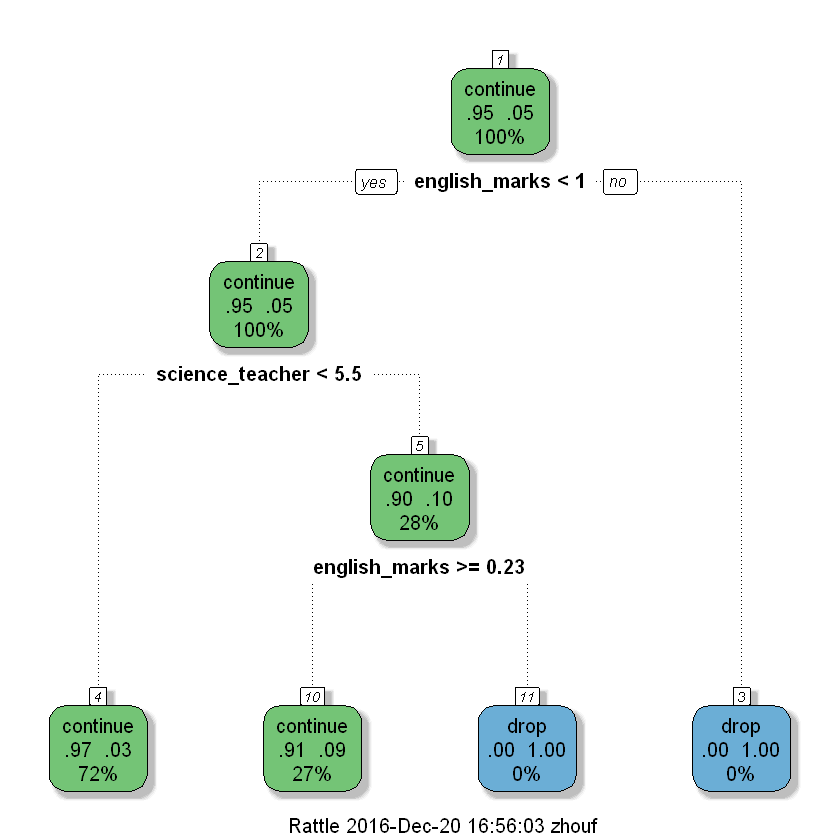

In [12]:
fancyRpartPlot(m.rp)

# Step 6.2: Evaluate - Decision Tree Model

As we have noted though, performing any evaluation on the training dataset provides a biased estimate of the actual performance. We must instead evaluate the performance of our models on a previously unseen dataset (at least unseen by the algorithm building the model).

So we now evaluate the model performance on the testing dataset.

In [13]:
# Score model

predictions <- predict(m.rp, ds[test, vars], type="prob")
threshold <- 0.5
rpart_probability <- predictions[, 2]
rpart_prediction <- ifelse(rpart_probability > threshold, 1, 0)
pred <- cbind(ds[test, vars], rpart_prediction, rpart_probability)
head(pred)

,continue_drop,gender,caste,mathematics_marks,english_marks,science_marks,science_teacher,languages_teacher,guardian,internet,total_students,total_toilets,establishment_year,rpart_prediction,rpart_probability
2,continue,f,bc,0.290,0.512,0.290,4,7,mother,true,356,14,1943,0,0.02535065
3,continue,f,oc,0.602,0.666,0.602,4,2,mother,false,179,8,1955,0,0.02535065
6,continue,f,bc,0.594,0.519,0.594,4,8,mother,true,335,43,1916,0,0.02535065
15,continue,f,bc,0.461,0.524,0.461,0,3,mother,true,469,14,1905,0,0.02535065
16,continue,f,oc,0.742,0.672,0.742,3,12,mother,true,132,14,1996,0,0.02535065
17,drop,f,bc,0.503,0.523,0.503,9,0,father,true,397,5,1950,0,0.08907655


        Predicted
Observed    0    1
       0 5475    0
       1  229   26


Accuracy Precision    Recall   F-Score 
0.9600349 1.0000000 0.1019608 0.1850534

Warning message in grid.Call.graphics(L_text, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"

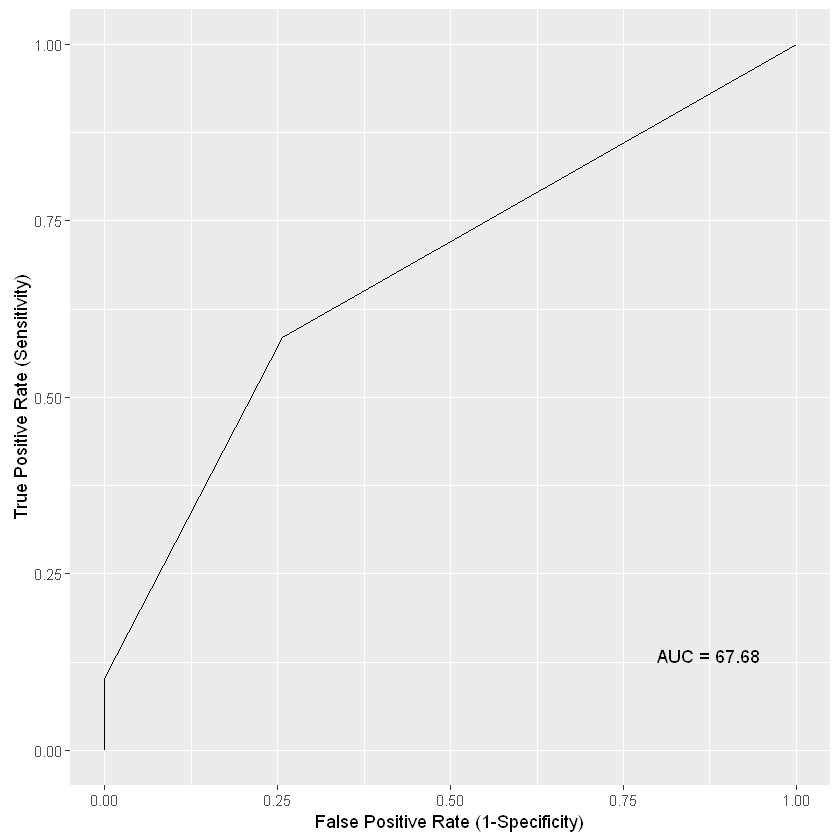

In [14]:
# Evaluate model

pred$continue_drop <- as.numeric(pred$continue_drop)-1

metrics.rp <- evaluateModel(data=pred,
                            observed="continue_drop",
                            predicted="rpart_prediction")
metrics.rp

rocChart(pr=pred$rpart_probability, target=pred$continue_drop)

# Step 6.3: Compare - Multiple Models using Experiment

We can repeat the modelling multiple times, randomly selecting different datasets for training, to get an estimate of the actual expected performance and variation we see in the performance. The helper function experi() can be used to assist us here. It is available as http://onepager.togaware.com/experi.R and we show some of the coding of experi() below.

In [15]:
# Show the function experi()

experi <- function(form, ds, dsname, target, modeller, details="",
                   n=100, control=NULL,
                   keep=FALSE, # Keep the last model built.
                   prob="prob",   
                   class="class",
                   log="experi.log")
{
 suppressPackageStartupMessages(require(pROC))
  
 user <- Sys.getenv("LOGNAME")
 node <- Sys.info()[["nodename"]]
 
 wsrpart.model <- modeller=="wsrpart"
 
 numclass <- length(levels(ds[,target]))
 
 start.time <- proc.time()
 
 seeds <- cors <- strs <- aucs <- accs <- NULL
 for (i in seq_len(n))
{
 loop.time <- proc.time()
 
 seeds <- c(seeds, seed <- sample(1:1000000, 1))
 set.seed(seed)
 
....

 result[-c(1:7)] <- round(result[-c(1:7)], 2)
 row.names(result) <- NULL
 if (keep)
 {
  if (numclass==2)
  {
   attr(result, "pr") <- pr
   attr(result, "test") <- test
  }
  attr(result, "model") <- model
 }
}
return(result)
}

Let's run the experiments using the algorihtms rpart (Therneau and Atkinson, 2014), randomForest (Breiman et al., 2012), ada (Culp et al., 2012), ctree() from party (Hothorn et al., 2013). In such way, we can conveniently implement those models and compare their performance.

In [16]:
# Source experi.R 

source("http://onepager.togaware.com/experi.R")

# Set the times of loops

n <- 10

# Run experiments

ex.rp <- experi(form, ds[vars], dsname, target, "rpart", "1", n=n, keep=TRUE)
ex.rf <- experi(form, ds[vars], dsname, target, "randomForest", "500", n=n, keep=TRUE, control=list(na.action=na.omit))
ex.ad <- experi(form, ds[vars], dsname, target, "ada", "50", n=n, keep=TRUE)
ex.ct <- experi(form, ds[vars], dsname, target, "ctree", "1", n=n, keep=TRUE)

# Compare results

results <- rbind(ex.rp, ex.rf, ex.ad, ex.ct)
rownames(results) <- results$modeller
results$modeller <- NULL
results

Loading required package: lubridate

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



,auc,auc.sd,cor,cor.sd,str,str.sd,acc,acc.sd,n,user,elapsed
rpart_1,0.99,0.02,NA,NA,NA,NA,1,0,10,4.09,4.32
randomForest_500,1.00,0.00,NA,NA,NA,NA,1,0,10,66.67,70.73
ada_50,1.00,0.00,NA,NA,NA,NA,1,0,10,155.28,156.28
ctree_1,1.00,0.00,NA,NA,NA,NA,1,0,10,5.56,5.68


# Step 7.1: Other Models - Support Vector Machine Model

Except for the above commonly used binary classification models, we could also try some more advanced models, for instance, svm(), support vector machine, nnet(), neural network, xgboost(), extreme gradient boosting, ect. We firstly build a svm() support vector machine model here.

In [ ]:
# Tune hyper-parameters

system.time({
m.svm.cv <- tune.svm(form, 
                     data=ds[train, vars], 
                     gamma=2^(-1:1), 
                     cost=2^(2:4), 
                     type="C-classification",
                     probability=TRUE,
                     scale=FALSE)
})

print(m.svm.cv$best.performance)

In [ ]:
# Train model: svm

system.time({
  m.svm <- svm(form, 
               data=ds[train, vars], 
               gamma=m.svm.cv$best.parameters[1], 
               cost=m.svm.cv$best.parameters[2],
               type="C-classification",
               probability = TRUE,
               scale = FALSE)
})

# Check the model information

m.svm

Then we score the model on testing dataset and evaluate the model performance.

In [ ]:
# Score model 

predictions <- predict(m.svm, ds[test, vars], probability=TRUE)
threshold <- 0.5
svm_probability <- attr(predictions, 'probabilities')[, 2]
svm_prediction <- ifelse(svm_probability > threshold, 1, 0)
pred <- cbind(ds[test, vars], svm_prediction, svm_probability)
head(pred)

In [ ]:
# Evaluate model

pred$continue_drop <- as.numeric(pred$continue_drop)-1

metrics.svm <- evaluateModel(data=pred,
                              observed="continue_drop",
                              predicted="svm_prediction")
metrics.svm

rocChart(pr=pred$svm_probability, target=pred$continue_drop)

# Step 7.2: Other Models - Neural Network Model

Next we build a nnet(), neural network model.

In [ ]:
# Tune hyper-parameters

system.time({
m.nnet.cv <- tune.nnet(form, 
                       data=ds[train, vars], 
                       size=c(6, 8, 10), 
                       decay=5*10^(-3:-1), 
                       rang=0.1,
                       maxit=200)
})

print(m.nnet.cv$best.performance)

In [ ]:
# Train model: nnet

system.time({
  m.nnet <- nnet(formula=form,
                 data=ds[train, vars],
                 size=m.nnet.cv$best.parameters[1], 
                 decay=m.nnet.cv$best.parameters[2], 
                 rang=0.1,
                 maxit=200)
})

# Check the model information

m.nnet

Then we score the model on testing dataset and evaluate the model performance.

In [ ]:
# Score model

predictions <- predict(m.nnet, ds[test, vars], type="raw")
threshold <- 0.5
nnet_probability <- predictions
nnet_prediction <- ifelse(nnet_probability > threshold, 1, 0)
pred <- cbind(ds[test, vars], nnet_prediction, nnet_probability)
head(pred)

In [ ]:
# Evaluate model

pred$continue_drop <- as.numeric(pred$continue_drop)-1

metrics.nnet <- evaluateModel(data=pred,
                              observed="continue_drop",
                              predicted="nnet_prediction")
metrics.nnet

rocChart(pr=pred$nnet_probability, target=pred$continue_drop)

# Step 7.3: Other Models - Extreme Gradient Boosting Model

Finally, we build a xgboost() extreme gradient boosting, as a specicial example, which performs well when dealing with unbalanced data. In our case, the proportion of student drop-out is around 5% in the original training dataset. Here we just use it as input to demonstrate the power of xgboost() in dealing with unbalanced data.

In [17]:
# Re-structure the training data set

traindata <- ds[train, inputs]

traindata[, c(1:ncol(traindata))] <- sapply(traindata[, c(1:ncol(traindata))], as.numeric) 
ntrain <- as.matrix(traindata[ , c(1:ncol(traindata))])

dtrain <- list()
dtrain$data <- Matrix(ntrain, sparse=TRUE)
dtrain$label <- as.numeric(as.data.frame(ds[train, target])[[1]]) - 1

dtrain %>% str()

List of 2
 $ data :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:158037] 0 1 2 3 4 5 6 7 8 9 ...
  .. ..@ p       : int [1:13] 0 13370 26740 40110 53480 66850 79090 91187 104557 117927 ...
  .. ..@ Dim     : int [1:2] 13370 12
  .. ..@ Dimnames:List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:12] "gender" "caste" "mathematics_marks" "english_marks" ...
  .. ..@ x       : num [1:158037] 1 1 1 1 1 1 1 2 2 2 ...
  .. ..@ factors : list()
 $ label: num [1:13370] 0 0 0 0 0 1 0 0 0 0 ...


In [19]:
# Tune hyper-parameters

cv.ctrl <- trainControl(method="cv",                     # specify resampling method to be cross-validation
                        number=5,                        # set the number of folds to be 5
                        verboseIter=FALSE,               # set to FALSE for not printing a training log
                        returnData=FALSE,                # set to FALSE for not saving the data
                        returnResamp="all",              # save losses across all models
                        classProbs=TRUE,                 # set to TRUE for class probabilities be computed for classification models 
                        summaryFunction=twoClassSummary, # specify a function AUC to compute performance metrics across resamples
                        allowParallel=TRUE)              # use a parallel backend if it is available

grid.xgb <- expand.grid(nrounds=2,
                        max_depth=2^(1:5),
                        eta=1*10^(-4:0),
                        min_child_weight=1,
                        colsample_bytree=1,
                        subsample=1,
                        gamma=0)

set.seed(45)
m.xgb.cv <-train(x=ntrain,
                 y=as.data.frame(ds[train, target])[[1]],
                 method="xgbTree",
                 trControl=cv.ctrl,
                 tuneGrid=grid.xgb,
                 verbose=TRUE,
                 metric="ROC",
                 nthread =2)

m.xgb.cv

eXtreme Gradient Boosting 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 10696, 10696, 10696, 10696, 10696 
Resampling results across tuning parameters:

  eta    max_depth  ROC        Sens       Spec      
  1e-04   2         0.6868065  1.0000000  0.05581395
  1e-04   4         0.7739779  1.0000000  0.22015504
  1e-04   8         0.9785562  0.9971709  0.66046512
  1e-04  16         0.9974816  1.0000000  0.98139535
  1e-04  32         0.9974816  1.0000000  0.98139535
  1e-03   2         0.6868065  1.0000000  0.05581395
  1e-03   4         0.7739779  1.0000000  0.22015504
  1e-03   8         0.9785562  0.9971709  0.66046512
  1e-03  16         0.9974816  1.0000000  0.98139535
  1e-03  32         0.9974816  1.0000000  0.98139535
  1e-02   2         0.6868065  1.0000000  0.05581395
  1e-02   4         0.7739779  1.0000000  0.22015504
  1e-02   8         0.9785562  0.9971709  0.66046512
  1e-02  16         0.9974816  1.0000000  0.98139535
  1e-02  32    

In [20]:
# Train model: xgboost

system.time({
  m.xgb <- xgboost(data=dtrain$data, 
                   label=dtrain$label,
                   nround=m.xgb.cv$bestTune[[1]], 
                   max.depth=m.xgb.cv$bestTune[[2]], 
                   eta=m.xgb.cv$bestTune[[3]], 
                   min_child_weight=1,
                   colsample_bytree=1,
                   subsample=1,
                   gamma=0,
                   nthread=2, 
                   objective="binary:logistic")
})

m.xgb

[1]	train-error:0.000000 
[2]	train-error:0.000000 


   user  system elapsed 
   0.08    0.00    0.06 

##### xgb.Booster
raw: 5.9 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max.depth = ..1, eta = ..2, min_child_weight = 1, 
    colsample_bytree = 1, subsample = 1, gamma = 0, nthread = 2, 
    objective = "binary:logistic")
params (as set within xgb.train):
  max_depth = "16", eta = "0.1", min_child_weight = "1", colsample_bytree = "1", subsample = "1", gamma = "0", nthread = "2", objective = "binary:logistic", silent = "1"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
  cb.save.model(save_period = save_period, save_name = save_name)
niter: 2
evaluation_log:
 iter train_error
    1           0
    2           0

In [21]:
# Calculate feature importance

importance <- xgb.importance(feature_names=dtrain$data@Dimnames[[2]], 
                             model=m.xgb)
print(importance)

             Feature       Gain       Cover  Frequency
1: mathematics_marks 0.30998281 0.147120885 0.27397260
2:     english_marks 0.21674073 0.320301422 0.16438356
3: languages_teacher 0.12209233 0.138141886 0.13698630
4:          guardian 0.09762265 0.120764467 0.08219178
5:             caste 0.09611334 0.078339736 0.15068493
6:            gender 0.08452394 0.003929090 0.08219178
7:   science_teacher 0.05576744 0.185562256 0.08219178
8:          internet 0.01715675 0.005840258 0.02739726


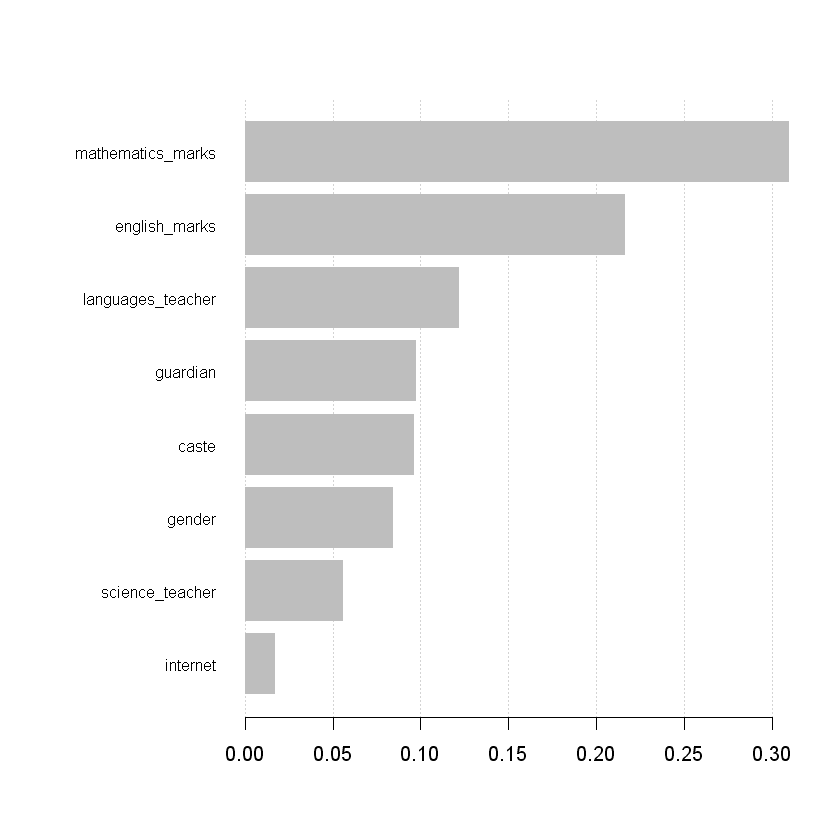

In [22]:
# Visualize feature importance

xgb.plot.importance(importance)

In [23]:
# Plot a boosted tree model

xgb.plot.tree(dtrain$data@Dimnames[[2]], model=m.xgb)

HTML widgets cannot be represented in plain text (need html)

Now we score the model on testing dataset and evaluate the model performance.

In [24]:
# Re-structure the testing data set

testdata <- ds[test, inputs]

testdata[, c(1:ncol(traindata))] <- sapply(testdata[, c(1:ncol(traindata))], as.numeric) 
ntest <- as.matrix(testdata[, c(1:ncol(traindata))])

dtest <- list()
dtest$data <- Matrix(ntest, sparse=TRUE)
dtest$label <- as.numeric(as.data.frame(ds[test, target])[[1]]) - 1

dtest %>% str()

List of 2
 $ data :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:67713] 0 1 2 3 4 5 6 7 8 9 ...
  .. ..@ p       : int [1:13] 0 5730 11460 17190 22920 28650 33860 39063 44793 50523 ...
  .. ..@ Dim     : int [1:2] 5730 12
  .. ..@ Dimnames:List of 2
  .. .. ..$ : NULL
  .. .. ..$ : chr [1:12] "gender" "caste" "mathematics_marks" "english_marks" ...
  .. ..@ x       : num [1:67713] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..@ factors : list()
 $ label: num [1:5730] 0 0 0 0 0 1 0 0 0 0 ...


In [25]:
# Score model

predictions <- predict(m.xgb, dtest$data)
threshold <- 0.5
xgboost_probability <- predictions
xgboost_prediction <- ifelse(xgboost_probability > threshold, 1, 0)
pred <- cbind(testdata, dtest$label, xgboost_prediction, xgboost_probability)
names(pred)[names(pred) == "dtest$label"] <- target
head(pred)

gender,caste,mathematics_marks,english_marks,science_marks,science_teacher,languages_teacher,guardian,internet,total_students,total_toilets,establishment_year,continue_drop,xgboost_prediction,xgboost_probability
1,1,0.290,0.512,0.290,4,7,3,2,356,14,1943,0,0,0.4057302
1,2,0.602,0.666,0.602,4,2,3,1,179,8,1955,0,0,0.4060442
1,1,0.594,0.519,0.594,4,8,3,2,335,43,1916,0,0,0.4057302
1,1,0.461,0.524,0.461,0,3,3,2,469,14,1905,0,0,0.4060442
1,2,0.742,0.672,0.742,3,12,3,2,132,14,1996,0,0,0.4057302
1,1,0.503,0.523,0.503,9,0,1,2,397,5,1950,1,1,0.5898832


        Predicted
Observed    0    1
       0 5475    0
       1    0  255


Accuracy Precision    Recall   F-Score 
        1         1         1         1

Warning message in grid.Call.graphics(L_text, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"

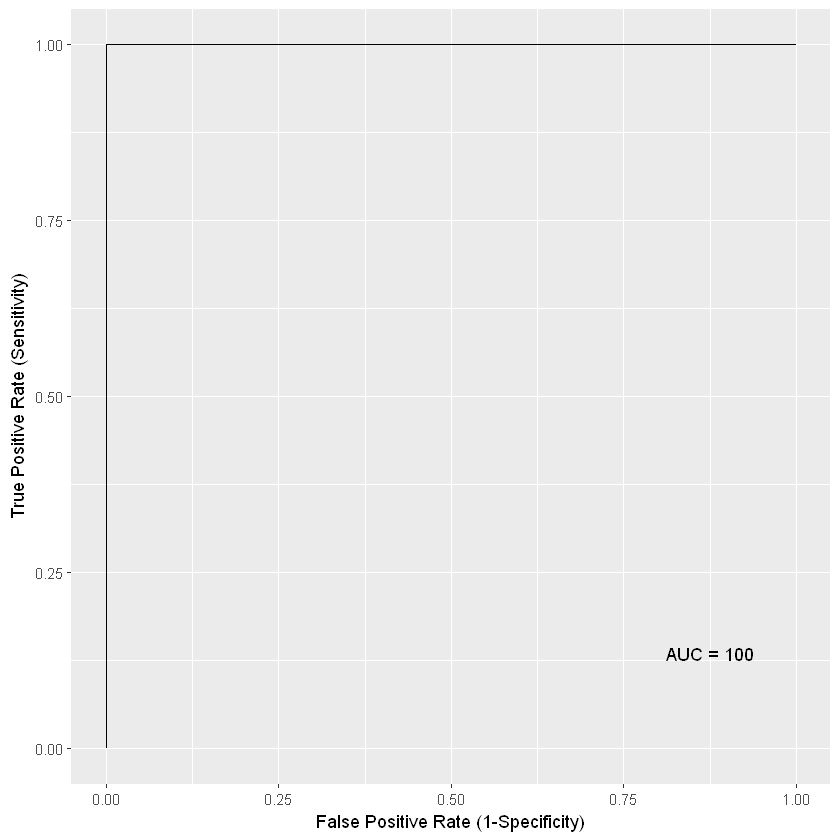

In [26]:
# Evaluate model

metrics.xgb <- evaluateModel(data=pred,
                             observed="continue_drop",
                             predicted="xgboost_prediction")
metrics.xgb

rocChart(pr=pred$xgboost_probability, target=pred$continue_drop)

# Step 8: Finish Up - Save Model

We save the model, together with the dataset and other variables, into a binary R file. Here, we use xgboost model as an example.

In [27]:
model <- m.xgb
mtype <- 'xgboost'
pr <- xgboost_probability
cl <- xgboost_prediction

dname <- "models"
if (! file.exists(dname)) dir.create(dname)
time.stamp <- format(Sys.time(), "%Y%m%d_%H%M%S")
fstem <- paste(dsname, mtype, time.stamp, sep="_")
(fname <- file.path(dname, sprintf("%s.RData", fstem)))

[1] "models/studentDropIndia_xgboost_20161220_165404.RData"

In [28]:
save(ds, dsname, vars, target, ignore,
form, nobs, seed, train, test, model, mtype, pr, cl,
file=fname)

We can then load this later and replicate the process.

In [29]:
(load(fname))

[1] "ds"     "dsname" "vars"   "target" "ignore" "form"   "nobs"   "seed"  
 [9] "train"  "test"   "model"  "mtype"  "pr"     "cl"

Note that by using generic variable names we can load different model files and perform common operations on them without changing the names within a script. However, do note that each time we load such a saved model file we overwrite any other variables of the same name.